# This notebook contains the code and figures for the data from measuring display latencies

What data do we have?

    A. Light intensity over time
    B. (A) for multiple trials
    C. (B) for different frame rate (FR), resolution, and modes
    D. (C) for different monitor/projector

What information to extract?

    A. How light is being shone by the monitor/projector in every trial
    B. How does the latency changes over time
    C. Distribution of light intensity for the whole experiment - histogram of (A)
    D. Distribution of latencies for the whole experiment
    E. (A, B, C, and D) across different FR, resolution, modes
    F. (A, B, C, and D) across different monitors (For the same FR, resolution, modes)
    G. Mean latency versus FR across across different monitors
    H. Mean latency versus Resolution across different monitors
    
Related to our device: 

    I. What is the sampling frequency of our device

---

In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter
import seaborn as sns
import os
import glob
from tqdm import tqdm

import vrlatency as vrl

## Import Data

In [2]:
path_data = "../../data/"
path_fig = "../../Figures/display/"

os.chdir(path_data)

In [3]:
df_data_all = pd.DataFrame()
df_params_all = pd.DataFrame()

for filename in tqdm(glob.glob('*.csv')):
    name = filename.split('.')[0]
    
    df_data = vrl.read_csv(filename)
    df_data['Session'] = name
    params = vrl.read_params(filename)
    params_series = pd.Series(params)
    params_series.name = name
    
    df_data_all = df_data_all.append(df_data)
    df_params_all = df_params_all.append(params_series)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:13<00:00,  2.04it/s]


In [4]:
df_params_all.head()

Date Depth         Experiment Height  \
display_20180830_115317  30.08.2018    32  DisplayExperiment   1080   
display_20180830_123133  30.08.2018    32  DisplayExperiment   1080   
display_20180830_123445  30.08.2018    32  DisplayExperiment   1024   
display_20180830_124007  30.08.2018    32  DisplayExperiment    720   
display_20180830_124242  30.08.2018    32  DisplayExperiment    768   

                                                            Monitors Rate  \
display_20180830_115317  SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009   60   
display_20180830_123133  SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009  120   
display_20180830_123445  SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009   60   
display_20180830_124007  SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009   60   
display_20180830_124242  SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009   60   

                             Time Trials Width  
display_20180830_115317  11:51:10   1000  1920  
display_20180830_123133  12:29:25   1000  1920  
display_20180830_123445  12:32:37   1000  1280  
display_20180830_124007  12:37:59   1000  1280  
display_20180830_124242  12:40:34   1000  1024

## Fix Params dataframe dtypes

In [5]:
dfp = df_params_all.copy()
int_params = ['Width', 'Height', 'Depth', 'Rate', 'Trials']
dfp[int_params] = df_params_all[int_params].astype(int)
dfp['Timestamp'] = pd.to_datetime(df_params_all.Date.str.cat(df_params_all.Time, sep=' '), format="%d.%m.%Y %H:%M:%S")
del dfp['Time']
del dfp['Date']
dfp.head().dtypes

Depth                  int32
Experiment            object
Height                 int32
Monitors              object
Rate                   int32
Trials                 int32
Width                  int32
Timestamp     datetime64[ns]
dtype: object

## Data Transformation

In [6]:
dfp['Pixels'] = dfp['Height'] * dfp['Width']
dfp.head(3)

Depth         Experiment  Height  \
display_20180830_115317     32  DisplayExperiment    1080   
display_20180830_123133     32  DisplayExperiment    1080   
display_20180830_123445     32  DisplayExperiment    1024   

                                                            Monitors  Rate  \
display_20180830_115317  SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009    60   
display_20180830_123133  SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009   120   
display_20180830_123445  SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009    60   

                         Trials  Width           Timestamp   Pixels  
display_20180830_115317    1000   1920 2018-08-30 11:51:10  2073600  
display_20180830_123133    1000   1920 2018-08-30 12:29:25  2073600  
display_20180830_123445    1000   1280 2018-08-30 12:32:37  1310720

In [7]:
df= df_data_all.copy()
df['Time'] = df['Time'] / 1000
trials = df.groupby(['Session', 'Trial'])
df['TrialTime'] = trials.Time.apply(lambda x: x - x.min())
df['Sample'] = trials.cumcount()
df['Session'] = pd.Categorical(df['Session'])
df.head()

Trial     Time  SensorBrightness                  Session  TrialTime  \
0      2  813.068                 0  display_20180830_115317      0.000   
1      2  813.340                 0  display_20180830_115317      0.272   
2      2  813.612                 0  display_20180830_115317      0.544   
3      2  813.884                 0  display_20180830_115317      0.816   
4      2  814.156                 0  display_20180830_115317      1.088   

   Sample  
0       0  
1       1  
2       2  
3       3  
4       4

In [8]:
df = df.reindex(['Session', 'Trial', 'Sample', 'Time', 'TrialTime', 'SensorBrightness'], axis=1)
df.head()

Session  Trial  Sample     Time  TrialTime  \
0  display_20180830_115317      2       0  813.068      0.000   
1  display_20180830_115317      2       1  813.340      0.272   
2  display_20180830_115317      2       2  813.612      0.544   
3  display_20180830_115317      2       3  813.884      0.816   
4  display_20180830_115317      2       4  814.156      1.088   

   SensorBrightness  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

Time to beat:

In [10]:
# %timeit vrl.get_display_latencies(dd)

current time:

In [11]:
# %load_ext line_profiler

In [12]:
# %timeit vrl.get_display_latencies(dd)

In [13]:
# %lprun -f vrl.get_display_latencies vrl.get_display_latencies(dd)

In [9]:
latencies = df.groupby('Session').apply(vrl.get_display_latencies, thresh=.75).unstack()
latencies.name = 'DisplayLatency'
latencies = latencies.reset_index()
latencies.head()

Trial                  Session       2       3       4       5       6  \
0      display_20180830_115317  38.488  29.504  28.664  19.376  34.672   
1      display_20180830_123133  12.000  14.504  15.608  17.768  15.320   
2      display_20180830_123445  25.416  38.256  21.312  24.592  36.600   
3      display_20180830_124007  31.176  34.696  31.112  30.016  22.376   
4      display_20180830_124242  21.304  35.264  24.000  30.568     NaN   

Trial       7       8       9      10   ...       992     993     994     995  \
0      23.232  30.608  29.248  33.880   ...    29.224  23.504  23.776  23.784   
1      15.856  15.544  17.472  20.464   ...    13.928  10.952  13.960     NaN   
2      22.416  36.872  30.064  33.632   ...    35.464  37.984  32.792  32.224   
3      25.944  21.896  37.960  21.032   ...       NaN  25.664  18.832  31.176   
4      34.400  30.864  34.672  33.600   ...    28.120  21.832  28.112  32.808   

Trial     996     997     998     999    1000    1001  
0      27.864  23.216  31.152  32.248  32.768  31.112  
1      14.248  19.088  13.384  19.136  19.904  19.128  
2      26.216  26.496  24.824  26.800  27.816  32.520  
3      35.240  35.216     NaN  28.432  32.472  30.360  
4      28.408  24.872  36.080  37.144  30.296  38.264  

[5 rows x 1001 columns]

In [10]:
latencies = df.groupby('Session').apply(vrl.get_display_latencies, thresh=.75).reset_index()
# latencies.name = 'DisplayLatency'
# latencies = latencies.reset_index()
latencies.head()

Session  Trial  DisplayLatency
0  display_20180830_115317      2          38.488
1  display_20180830_115317      3          29.504
2  display_20180830_115317      4          28.664
3  display_20180830_115317      5          19.376
4  display_20180830_115317      6          34.672

In [11]:
dfl = pd.merge(df, latencies, on=['Session', 'Trial'])
dfl['TrialTransitionTime'] = dfl['TrialTime'] - dfl['DisplayLatency']
dfl.head()

Session  Trial  Sample     Time  TrialTime  \
0  display_20180830_115317      2       0  813.068      0.000   
1  display_20180830_115317      2       1  813.340      0.272   
2  display_20180830_115317      2       2  813.612      0.544   
3  display_20180830_115317      2       3  813.884      0.816   
4  display_20180830_115317      2       4  814.156      1.088   

   SensorBrightness  DisplayLatency  TrialTransitionTime  
0                 0          38.488              -38.488  
1                 0          38.488              -38.216  
2                 0          38.488              -37.944  
3                 0          38.488              -37.672  
4                 0          38.488              -37.400

## Session Analysis

### Looping over all the trials and getting the transition sample number

In [12]:
def get_transition_samplenum(session):
    transition_samples = []
    for _, trial in session.groupby('Trial'):
        try:
            transition_sample = trial[trial.TrialTransitionTime == 0].Sample.values[0]
        except:
            transition_sample = np.nan
        
        transition_samples.append(transition_sample)
    
    return transition_samples

## Shifting slower trials to the onset of the fastest trial

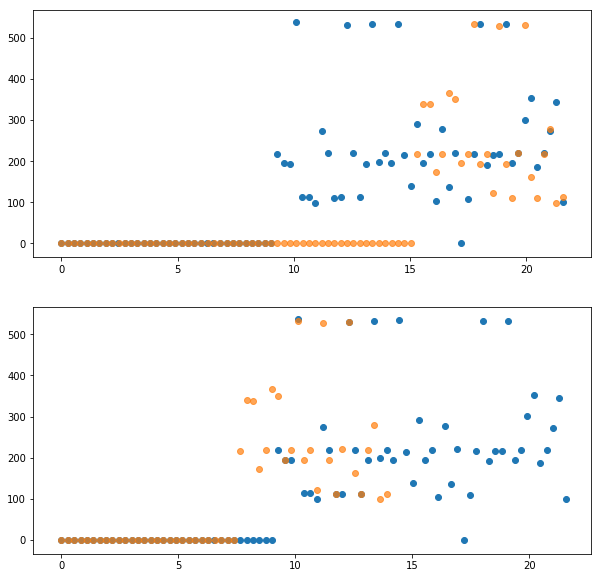

In [13]:
sess_id = 1
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session]

fastest_trial = dd[dd.DisplayLatency == dd.DisplayLatency.min()]
fastest_trialnum = fastest_trial.Trial.unique()[0]

test_trialnum = 50
test_trial = dd[dd.Trial == test_trialnum]

fastest_transtion_sample = fastest_trial[fastest_trial.TrialTransitionTime == 0].Sample.values[0]
test_transition_sample = test_trial[test_trial.TrialTransitionTime == 0].Sample.values[0]
offset = test_transition_sample - fastest_transtion_sample

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))
ax1.scatter(fastest_trial.TrialTime, fastest_trial.SensorBrightness);
ax1.scatter(test_trial.TrialTime, test_trial.SensorBrightness, alpha=.7);

ax2.scatter(fastest_trial.TrialTime, fastest_trial.SensorBrightness);
ax2.scatter(test_trial.TrialTime.values[offset:] + (test_trial.TrialTime.values.min() - test_trial.TrialTime.values[offset]), 
            test_trial.SensorBrightness.values[offset:], alpha=0.7);

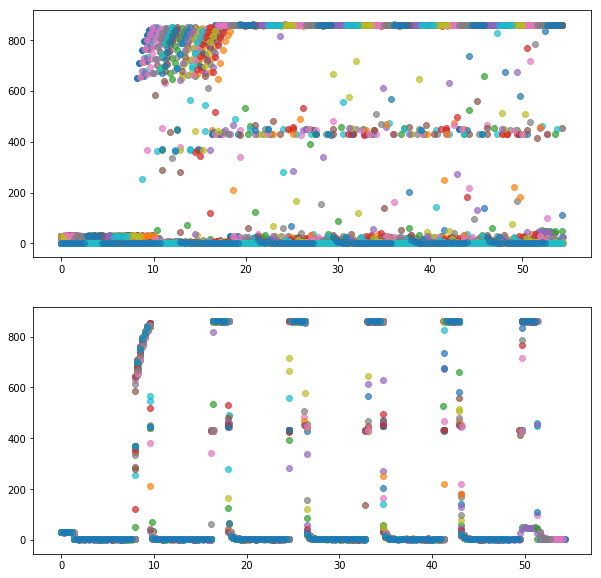

In [14]:
sess_id = 19  #16
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session]

fastest_trial = dd[dd.DisplayLatency == dd.DisplayLatency.min()]
fastest_trialnum = fastest_trial.Trial.unique()[0]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))
ax1.scatter(fastest_trial.TrialTime, fastest_trial.SensorBrightness);
ax2.scatter(fastest_trial.TrialTime, fastest_trial.SensorBrightness);

for trial in range(dd.Trial.min(), dd.Trial.max(), 20):

    test_trialnum = trial
    test_trial = dd[dd.Trial == test_trialnum]

    fastest_transtion_sample = fastest_trial[fastest_trial.TrialTransitionTime == 0].Sample.values[0]
    test_transition_sample = test_trial[test_trial.TrialTransitionTime == 0].Sample.values[0]
    offset = test_transition_sample - fastest_transtion_sample

    ax1.scatter(test_trial.TrialTime, test_trial.SensorBrightness, alpha=.7);
    ax2.scatter(test_trial.TrialTime.values[offset:] + (test_trial.TrialTime.values.min() - test_trial.TrialTime.values[offset]), 
                test_trial.SensorBrightness.values[offset:], alpha=0.7);

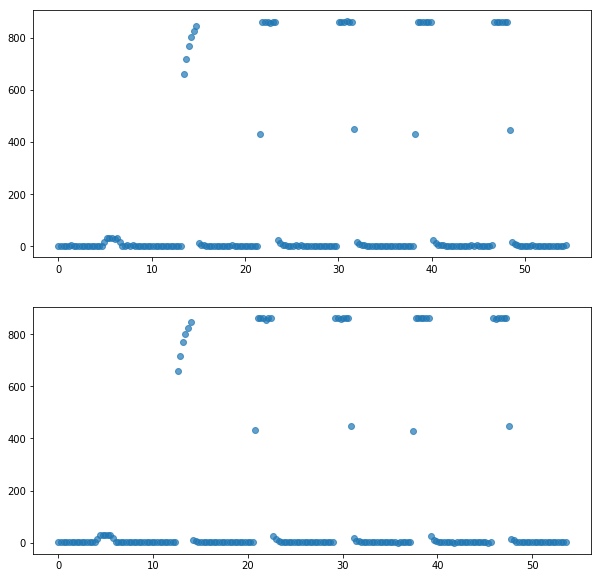

In [15]:
sess_id = 19  #16
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session]

hh = np.array(get_transition_samplenum(dd))
hh = hh[~np.isnan(hh)]
hh = hh.astype(int)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))

shifted_trials = pd.DataFrame()

for test_trialnum in range(3,4): #range(dd.Trial.min(), dd.Trial.max(), 100):
    
    test_trial = dd[dd.Trial == test_trialnum]

    fastest_transtion_sample = hh.mean().round().astype(int)
    test_transition_sample = test_trial[test_trial.TrialTransitionTime == 0].Sample.values[0]
    offset = test_transition_sample - fastest_transtion_sample
    
    shifted_trial = test_trial.SensorBrightness[offset:].to_frame().reset_index(drop=True)
    shifted_trial['Sample'] = range(0, shifted_trial.shape[0])
    shifted_trial['Trial'] = test_trialnum
    shifted_trial['TrialTime'] = test_trial.TrialTime.values[offset:] + (test_trial.TrialTime.values.min() - test_trial.TrialTime.values[offset])
    shifted_trials = shifted_trials.append(shifted_trial)
    
    ax1.scatter(test_trial.TrialTime, test_trial.SensorBrightness, alpha=.7);
    ax2.scatter(test_trial.TrialTime.values[offset:] + (test_trial.TrialTime.values.min() - test_trial.TrialTime.values[offset]), 
                test_trial.SensorBrightness.values[offset:], alpha=0.7);

In [16]:
average_time = shifted_trials.groupby('Sample').TrialTime.mean()
average_brightness = shifted_trials.groupby('Sample').SensorBrightness.mean()

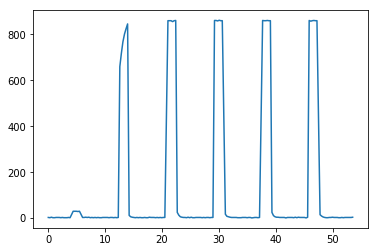

In [17]:
plt.plot(average_time, average_brightness)

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:14<00:00, 70.89it/s]


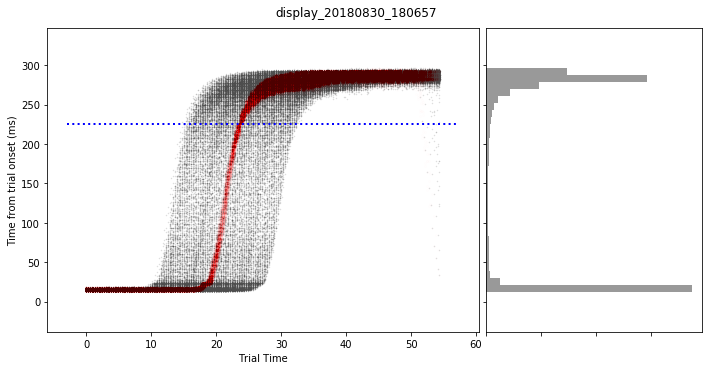

In [130]:
sess_id = 14
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session]

hh = np.array(get_transition_samplenum(dd))
hh = hh[~np.isnan(hh)]
hh = hh.astype(int)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw = {'width_ratios': [2, 1]}, sharey=True)
ax1, ax2 = axes

ax1.scatter(dd.TrialTime, dd.SensorBrightness, c='.3', s=.2, alpha=.2);

shifted_trials = pd.DataFrame()

for trial in tqdm(range(dd.Trial.min(), dd.Trial.max(), 1)):

    test_trialnum = trial
    test_trial = dd[dd.Trial == test_trialnum]

    fastest_transtion_sample = hh.mean().round().astype(int)

    try:
        test_transition_sample = test_trial[test_trial.TrialTransitionTime == 0].Sample.values[0]
        offset = test_transition_sample - fastest_transtion_sample
    except IndexError:
        offset = -1

    if offset >= 0:
#         ax1.scatter(test_trial.TrialTime.values[offset:] + (test_trial.TrialTime.values.min() - test_trial.TrialTime.values[offset]), 
#                     test_trial.SensorBrightness.values[offset:], c='r', s=1, alpha=.05);
        shifted_trial = test_trial.SensorBrightness[offset:].to_frame().reset_index(drop=True)
        shifted_trial['Sample'] = range(0, shifted_trial.shape[0])
        shifted_trial['Trial'] = test_trialnum
        shifted_trial['TrialTime'] = test_trial.TrialTime.values[offset:] + (test_trial.TrialTime.values.min() - test_trial.TrialTime.values[offset])
        shifted_trials = shifted_trials.append(shifted_trial)
        
ax1.scatter(shifted_trials.TrialTime, shifted_trials.SensorBrightness, c='r', s=8, alpha=.002)

# average_time = shifted_trials.groupby('Sample').TrialTime.mean()
# average_brightness = shifted_trials.groupby('Sample').SensorBrightness.mean()
# ax1.plot(average_time, average_brightness, 'r', alpha=.5, linewidth=2)
# ax1.scatter(average_time, average_brightness, c='r')
        
thresh = 0.75
ax1.hlines([vrl.perc_range(dd['SensorBrightness'], thresh)], *ax1.get_xlim(), 'b', label='Threshold', linewidth=2, linestyle='dotted');

sns.distplot(dd['SensorBrightness'].values, ax=ax2, vertical=True, hist_kws={'color': 'k'}, kde_kws={'alpha': 0})
ax2.set(xticklabels='')

ax1.set(xlabel='Trial Time', ylabel='Time from trial onset (ms)')

fig.suptitle(session, y=1.02)
fig.tight_layout(w_pad=0)
fig;

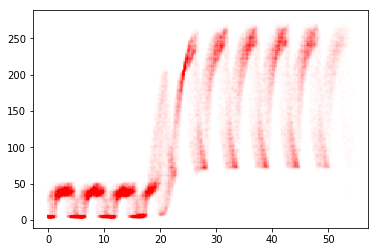

In [121]:
plt.scatter(shifted_trials.TrialTime, shifted_trials.SensorBrightness, c='r', s=8, alpha=.002)

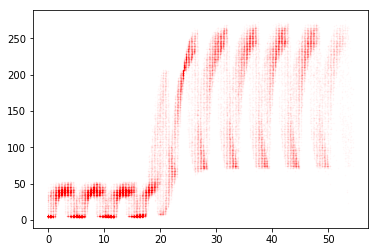

In [116]:
plt.scatter(shifted_trials.TrialTime, shifted_trials.SensorBrightness, c='r', s=.2, alpha=.02)

In [24]:
grp = shifted_trials.groupby('Trial')

In [39]:
aa = list(dict(list(grp)).keys())

In [82]:
ref_trial = grp.get_group(test_trialnum)
test_trial = grp.get_group(aa[20])

In [83]:
corr = np.correlate(ref_trial.SensorBrightness.values, test_trial.SensorBrightness.values, mode='same')

7


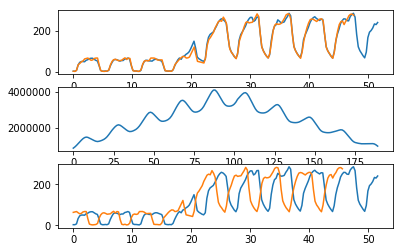

In [85]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
ax1.plot(ref_trial.TrialTime, ref_trial.SensorBrightness)
ax1.plot(test_trial.TrialTime, test_trial.SensorBrightness)

ax2.plot(corr)

offset = ref_trial.shape[0] // 2 - np.where(corr == corr.max())[0][0]
print(offset)
ax3.plot(ref_trial.TrialTime, ref_trial.SensorBrightness)
ax3.plot(test_trial.TrialTime[offset:] - (test_trial.TrialTime[offset] - test_trial.TrialTime[0]), test_trial.SensorBrightness[offset:])

100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:06<00:00, 149.51it/s]


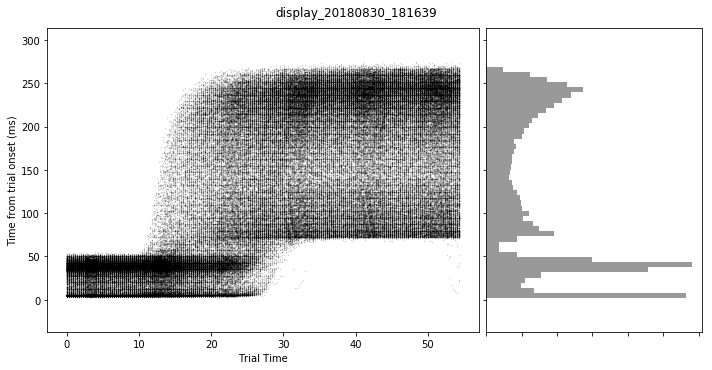

In [129]:
sess_id = 16
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session]

hh = np.array(get_transition_samplenum(dd))
hh = hh[~np.isnan(hh)]
hh = hh.astype(int)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw = {'width_ratios': [2, 1]}, sharey=True)
ax1, ax2 = axes

ax1.scatter(dd.TrialTime, dd.SensorBrightness, c='k', s=.2, alpha=.2);

shifted_trials = pd.DataFrame()

for trial in tqdm(range(dd.Trial.min(), dd.Trial.max(), 1)):

    test_trialnum = trial
    test_trial = dd[dd.Trial == test_trialnum]

    fastest_transtion_sample = hh.mean().round().astype(int)

    try:
        test_transition_sample = test_trial[test_trial.TrialTransitionTime == 0].Sample.values[0]
        offset = test_transition_sample - fastest_transtion_sample
    except IndexError:
        offset = -1

    if offset == 0:
#         ax1.scatter(test_trial.TrialTime.values[offset:] + (test_trial.TrialTime.values.min() - test_trial.TrialTime.values[offset]), 
#                     test_trial.SensorBrightness.values[offset:], c='r', s=1, alpha=.05);
        shifted_trial = test_trial.SensorBrightness[offset:].to_frame().reset_index(drop=True)
        shifted_trial['Sample'] = range(0, shifted_trial.shape[0])
        shifted_trial['Trial'] = test_trialnum
        shifted_trial['TrialTime'] = test_trial.TrialTime.values[offset:] + (test_trial.TrialTime.values.min() - test_trial.TrialTime.values[offset])
        shifted_trials = shifted_trials.append(shifted_trial)

average_time = shifted_trials.groupby('Sample').TrialTime.mean()
average_brightness = shifted_trials.groupby('Sample').SensorBrightness.mean()
# ax1.plot(average_time, average_brightness, 'r', alpha=.5, linewidth=2)
# ax1.scatter(average_time, average_brightness, c='r')
        
thresh = 0.75
# ax1.hlines([vrl.perc_range(dd['SensorBrightness'], thresh)], *ax1.get_xlim(), 'b', label='Threshold', linewidth=2, linestyle='dotted');

sns.distplot(dd['SensorBrightness'].values, ax=ax2, vertical=True, hist_kws={'color': 'k'}, kde_kws={'alpha': 0})
ax2.set(xticklabels='')

ax1.set(xlabel='Trial Time', ylabel='Time from trial onset (ms)')

fig.suptitle(session, y=1.02)
fig.tight_layout(w_pad=0)
fig;

In [147]:
grp = dd.groupby('SensorBrightness').TrialTime.mean().to_frame()
grp.reset_index(inplace=True)
grp

SensorBrightness  TrialTime
0                   2   4.648000
1                   3   9.357479
2                   4   9.072383
3                   5   9.493886
4                   6  10.209786
5                   7  12.369373
6                   8  12.967561
7                   9  12.156640
8                  10  12.465226
9                  11  11.817353
10                 12  11.560035
11                 13  11.208894
12                 14  11.438592
13                 15  11.117238
14                 16  11.305908
15                 17  11.397852
16                 18  10.732839
17                 19  11.288398
18                 20  10.853868
19                 21  11.086845
20                 22  11.112194
21                 23  11.112618
22                 24  10.975076
23                 25  10.694591
24                 26  11.492873
25                 27  10.901093
26                 28  10.454209
27                 29  10.345629
28                 30  10.261725
29                 31  10.635074
..                ...        ...
244               246  40.317322
245               247  40.248414
246               248  40.468731
247               249  39.966337
248               250  40.146815
249               251  40.361936
250               252  40.028480
251               253  40.603708
252               254  40.258225
253               255  40.750171
254               256  40.589560
255               257  41.226597
256               258  41.416856
257               259  41.302408
258               260  41.523247
259               261  41.646254
260               262  42.440732
261               263  42.283248
262               264  42.457413
263               265  42.487484
264               266  43.738725
265               267  42.140283
266               268  44.441589
267               269  43.595478
268               270  43.982788
269               271  42.007333
270               272  42.316364
271               273  47.836000
272               274  44.354667
273               275  53.280000

[274 rows x 2 columns]

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:13<00:00, 74.87it/s]
c:\users\mohammad bashiri\anaconda3\envs\vrlatency3\lib\site-packages\matplotlib-2.2.2-py3.6-win-amd64.egg\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
 40%|███████████████████████████████▊                                                | 398/999 [00:05<00:07, 79.54it/s]


KeyboardInterrupt: 

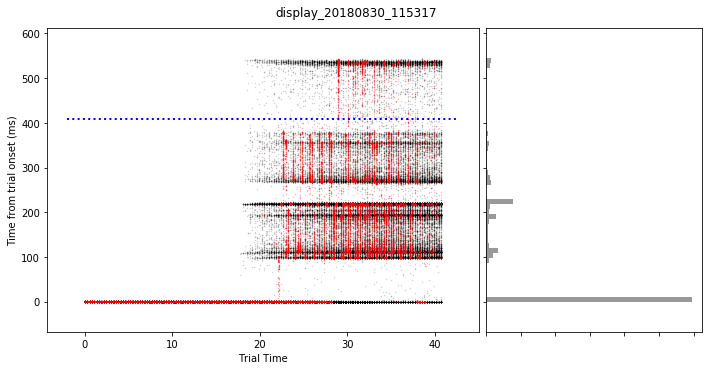

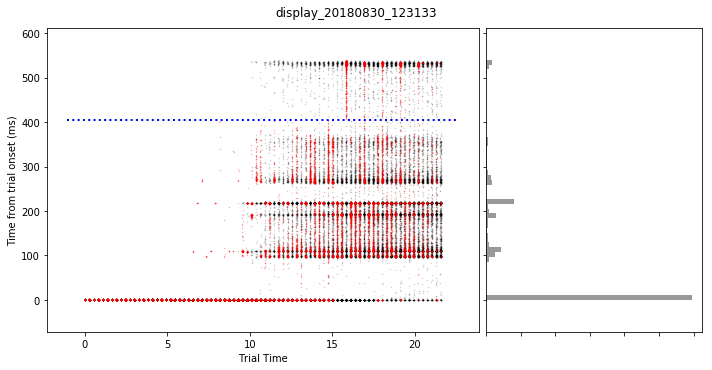

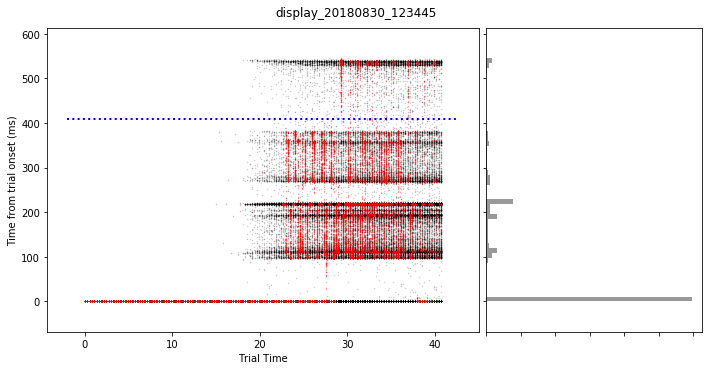

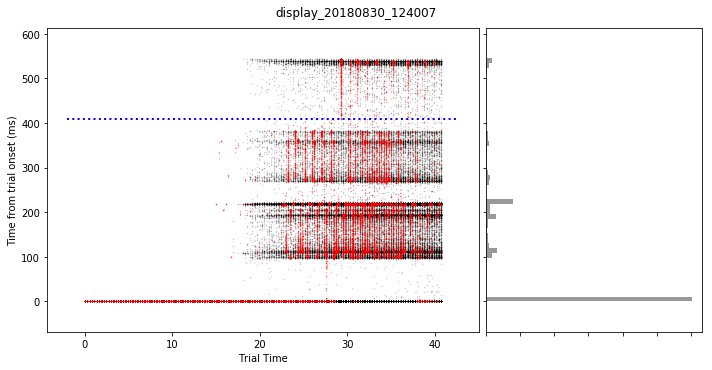

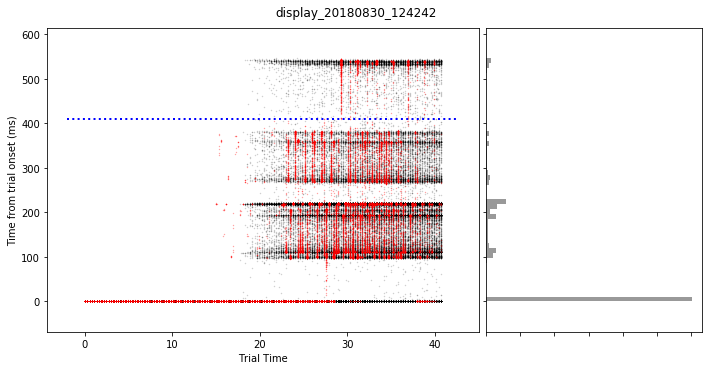

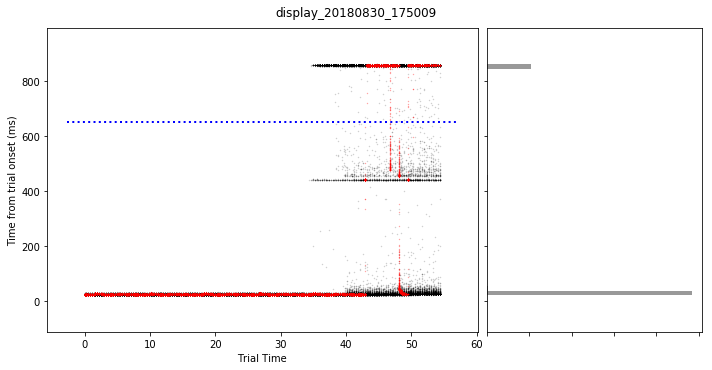

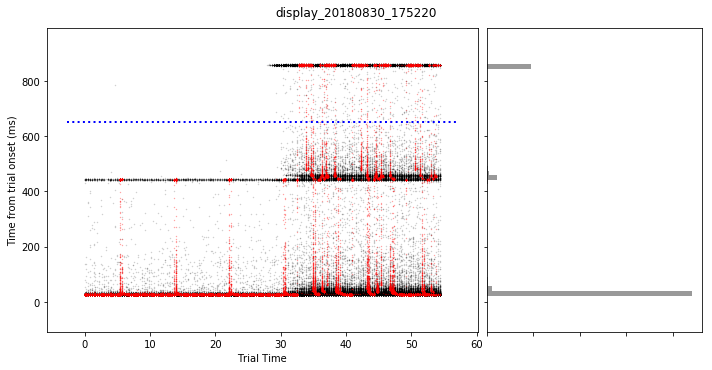

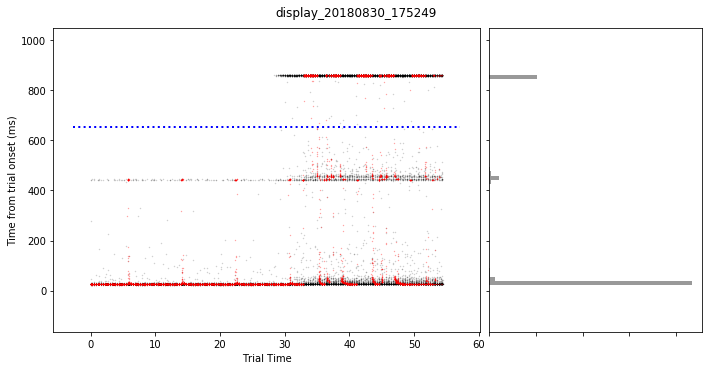

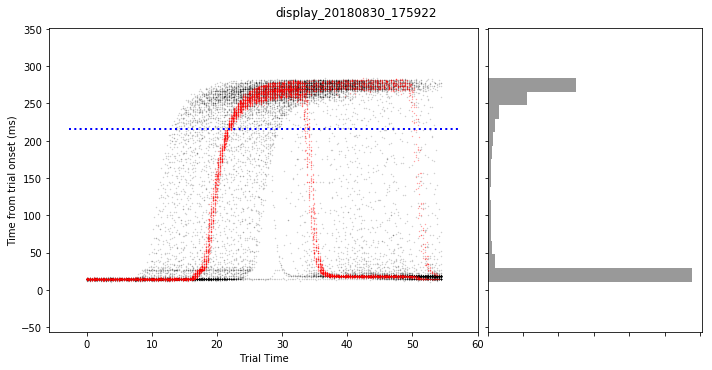

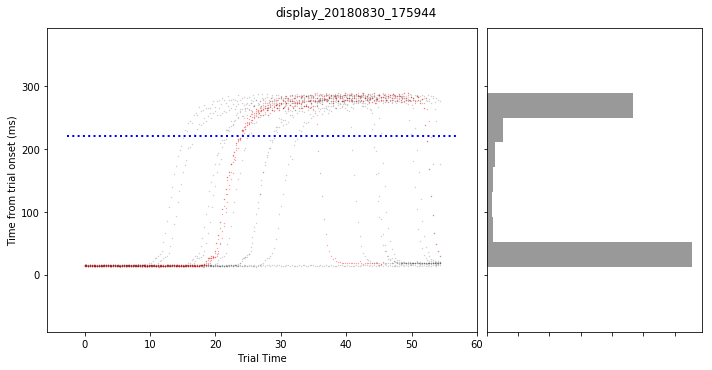

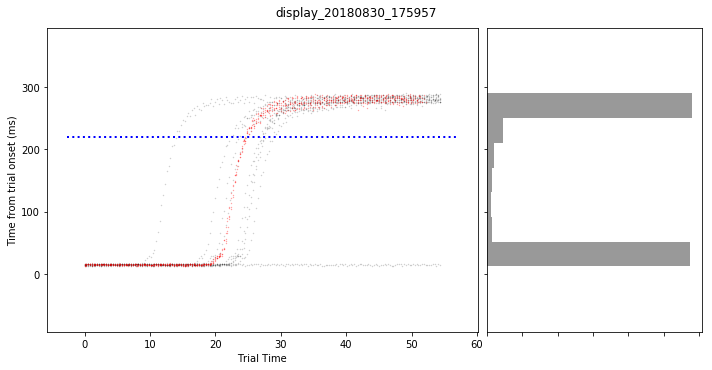

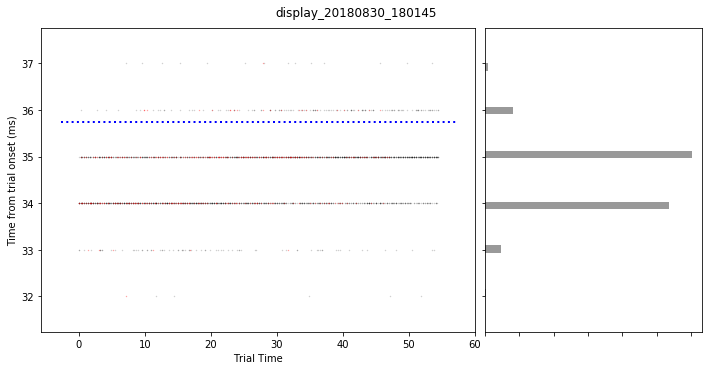

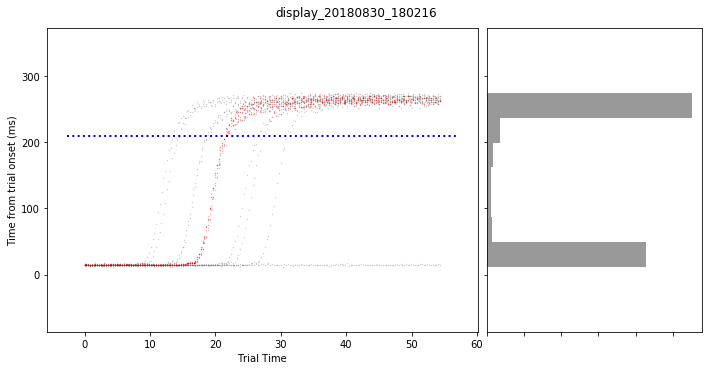

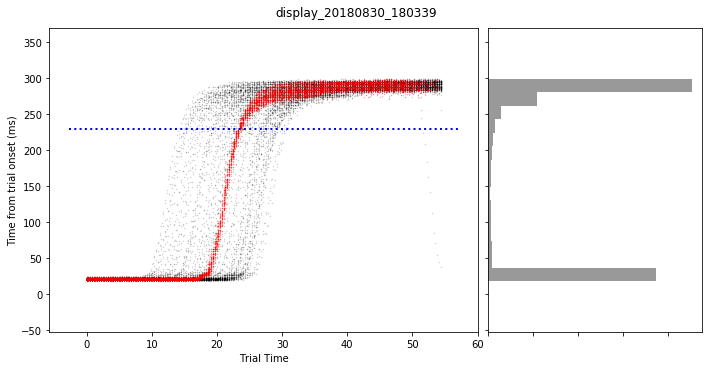

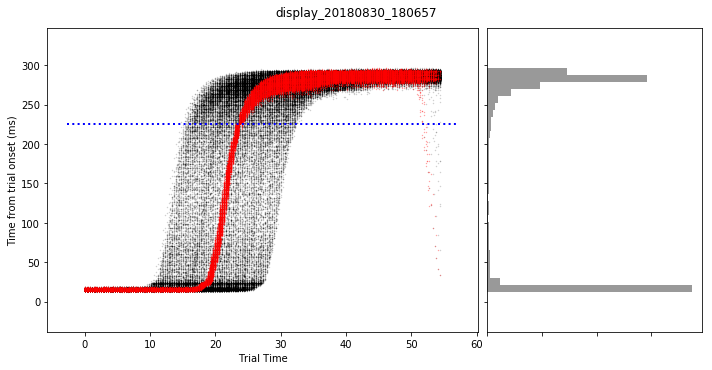

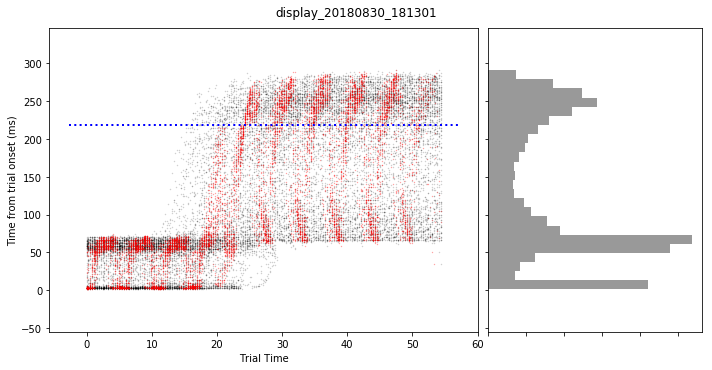

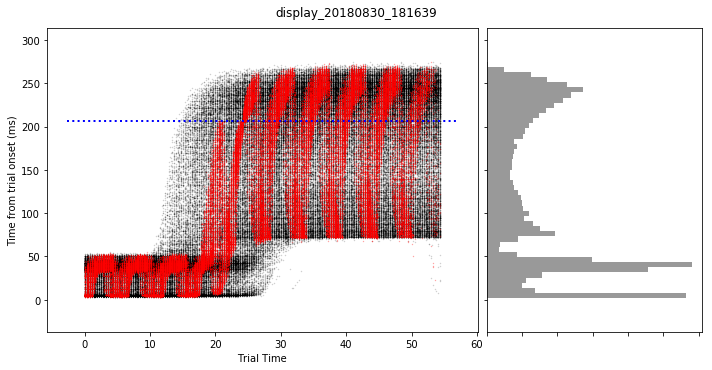

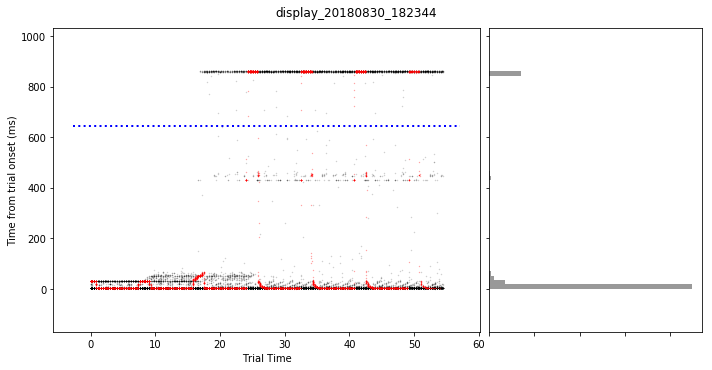

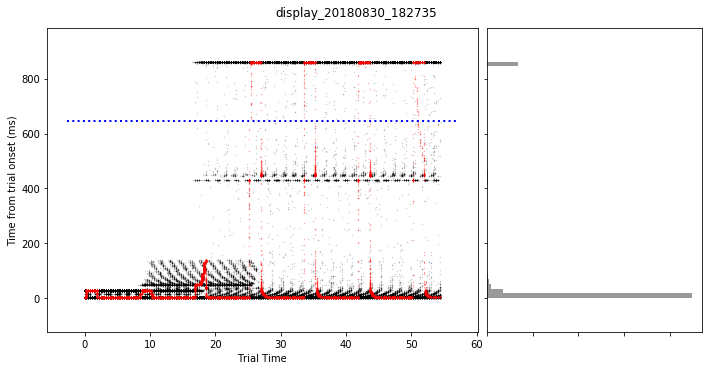

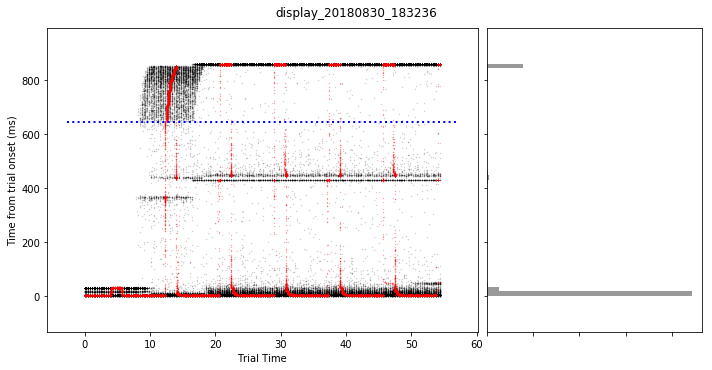

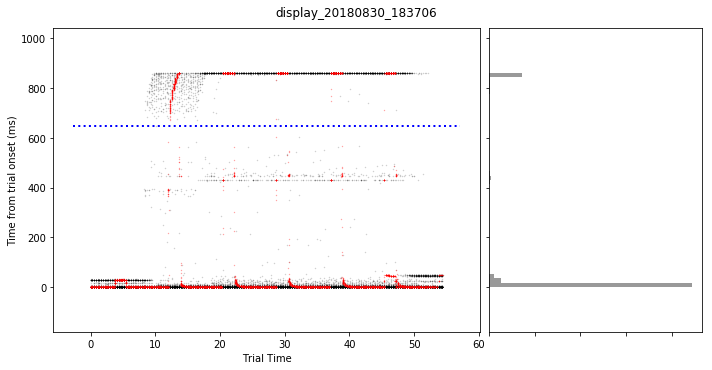

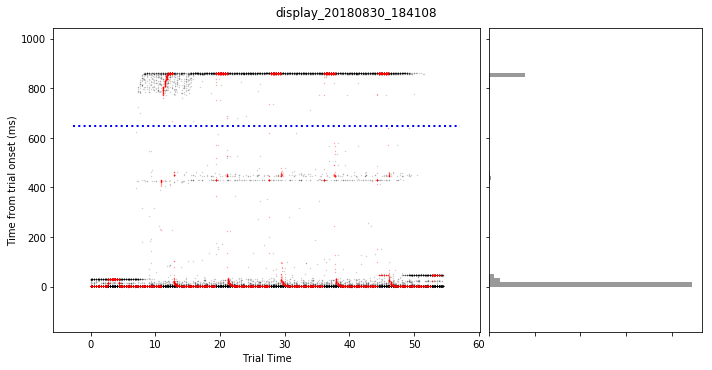

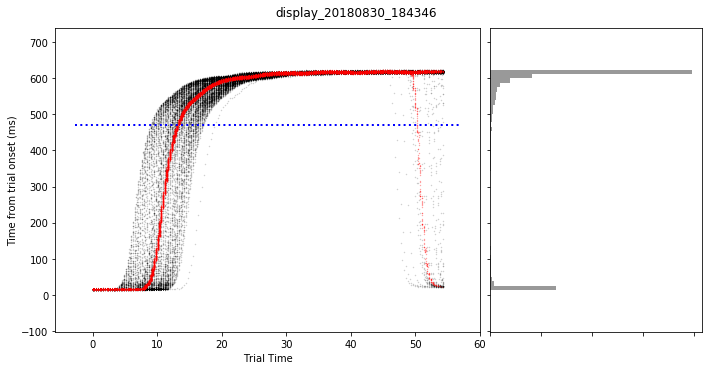

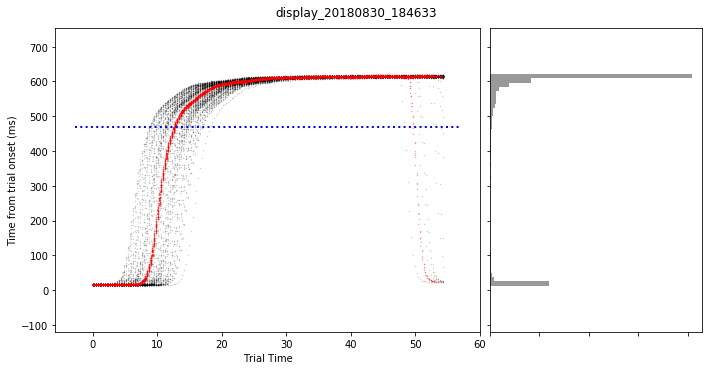

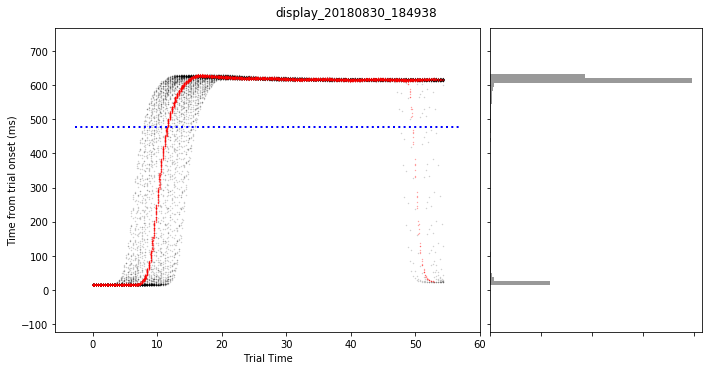

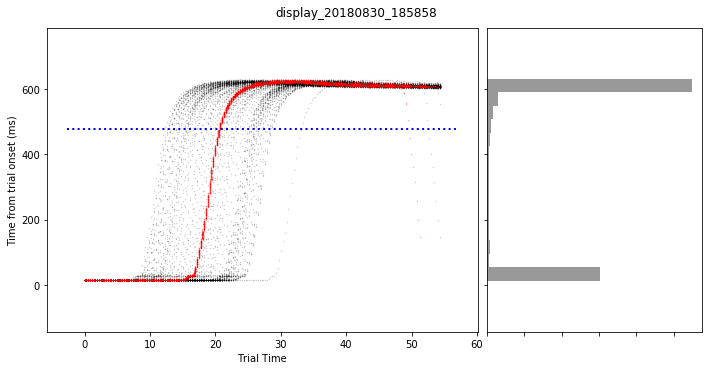

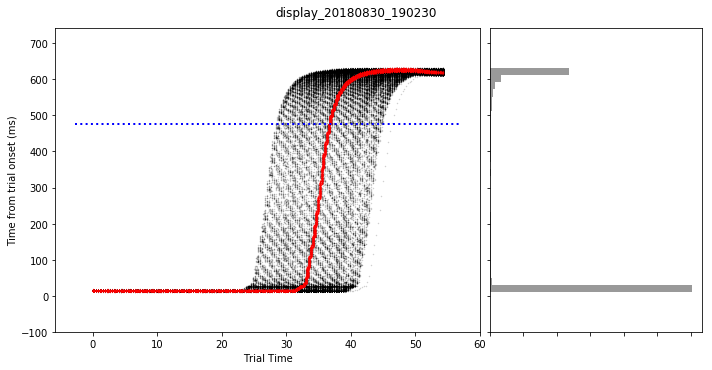

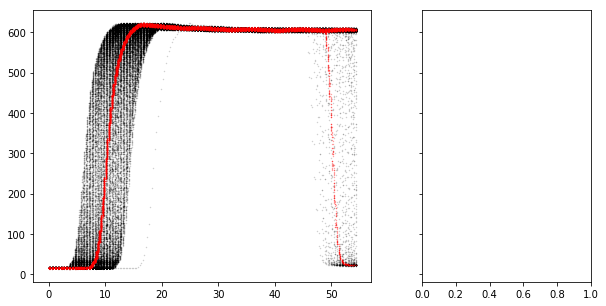

In [16]:
# sess_id = 0  #16
for sess_id in range(0, 28):
    session = dfp.iloc[sess_id].name
    dd = dfl[dfl['Session'] == session]

    hh = np.array(get_transition_samplenum(dd))
    hh = hh[~np.isnan(hh)]
    hh = hh.astype(int)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw = {'width_ratios': [2, 1]}, sharey=True)
    ax1, ax2 = axes

    ax1.scatter(dd.TrialTime, dd.SensorBrightness, c='k', s=.2, alpha=.2);

    for trial in tqdm(range(dd.Trial.min(), dd.Trial.max(), 1)):

        test_trialnum = trial
        test_trial = dd[dd.Trial == test_trialnum]

        fastest_transtion_sample = hh.mean().round().astype(int)

        try:
            test_transition_sample = test_trial[test_trial.TrialTransitionTime == 0].Sample.values[0]
            offset = test_transition_sample - fastest_transtion_sample
        except IndexError:
            offset = -1

        if offset >= 0:
            ax1.scatter(test_trial.TrialTime.values[offset:] + (test_trial.TrialTime.values.min() - test_trial.TrialTime.values[offset]), 
                        test_trial.SensorBrightness.values[offset:], c='r', s=.1, alpha=.5);

    thresh = 0.75
    ax1.hlines([vrl.perc_range(dd['SensorBrightness'], thresh)], *ax1.get_xlim(), 'b', label='Threshold', linewidth=2, linestyle='dotted');

    sns.distplot(dd['SensorBrightness'].values, ax=ax2, vertical=True, hist_kws={'color': 'k'}, kde_kws={'alpha': 0})
    ax2.set(xticklabels='')

    ax1.set(xlabel='Trial Time', ylabel='Time from trial onset (ms)')

    fig.suptitle(session, y=1.02)
    fig.tight_layout(w_pad=0)
    fig;
    plt.savefig(path_fig + session + '_' + str(sess_id) + '_brightness.png')

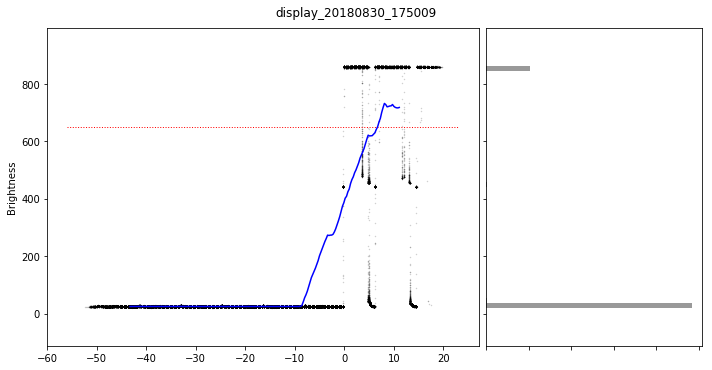

In [30]:
sess_id = 5
session = dfp.iloc[sess_id].name
dd = dfl[dfl['Session'] == session]


fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw = {'width_ratios': [2, 1]}, sharey=True)
ax1, ax2 = axes


ax1.scatter(dd['TrialTransitionTime'], dd['SensorBrightness'], s=.2, alpha=.2, c='k') #c='0.7', linewidth=.6)

ax1.plot(dd.groupby('Sample').TrialTransitionTime.mean(), dd.groupby('Sample').SensorBrightness.mean().values, c='b', label='Average')

thresh = 0.75
ax1.hlines([vrl.perc_range(dd['SensorBrightness'], thresh)], *ax1.get_xlim(), 'r', label='Threshold', linewidth=1, linestyle='dotted')
ax1.set(ylabel='Brightness')

## Fig 2
sns.distplot(dd['SensorBrightness'].values, ax=ax2, vertical=True, hist_kws={'color': 'k'}, kde_kws={'alpha': 0})
ax2.set(xticklabels='')

# axs2.set_
# ax2.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
fig.tight_layout(w_pad=0)
fig.suptitle(session, y=1.02)    
fig;

## Latencies

c:\users\mohammad bashiri\anaconda3\envs\vrlatency3\lib\site-packages\matplotlib-2.2.2-py3.6-win-amd64.egg\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


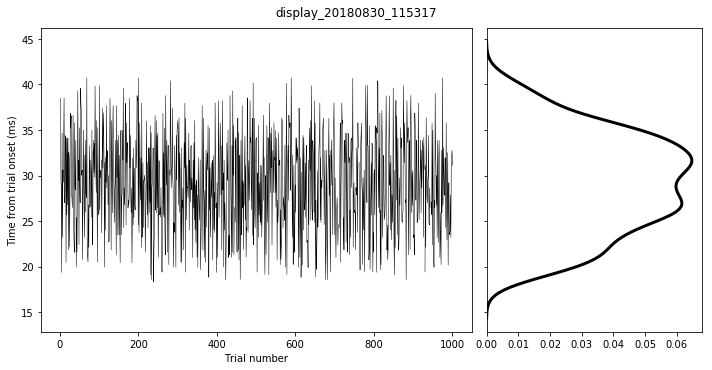

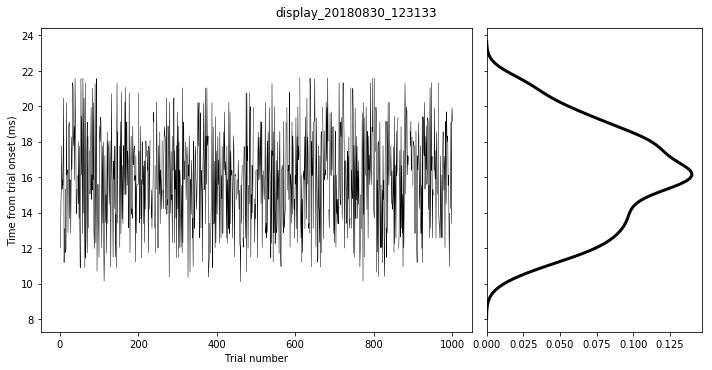

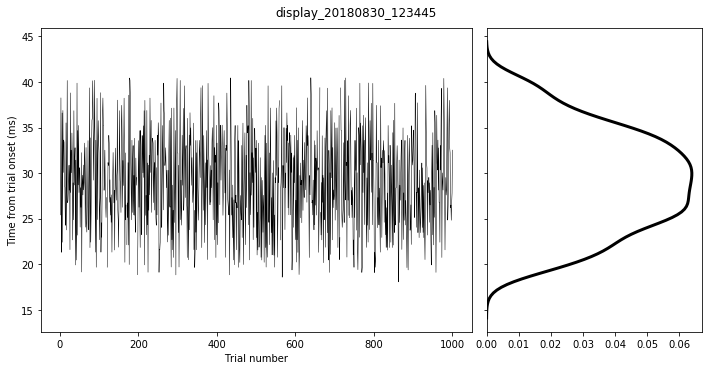

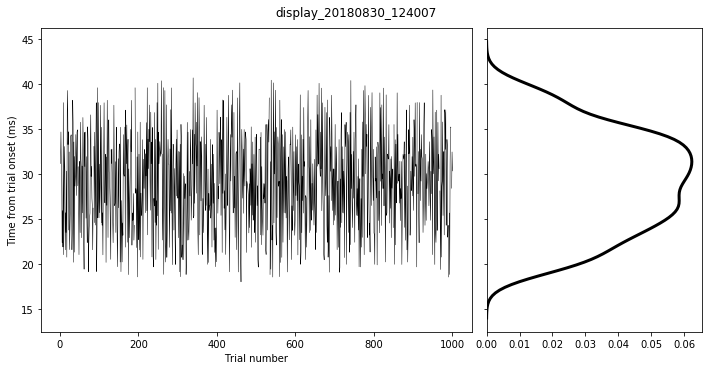

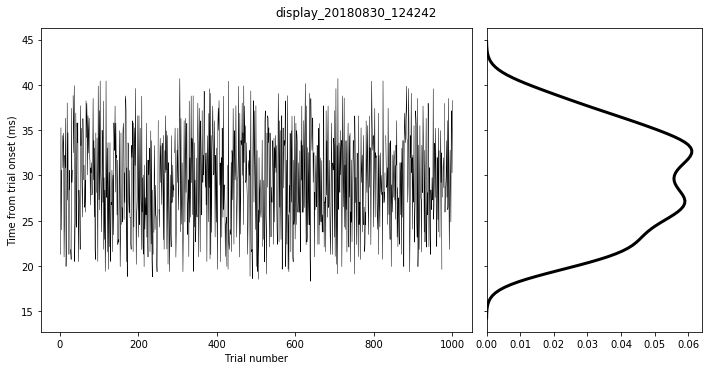

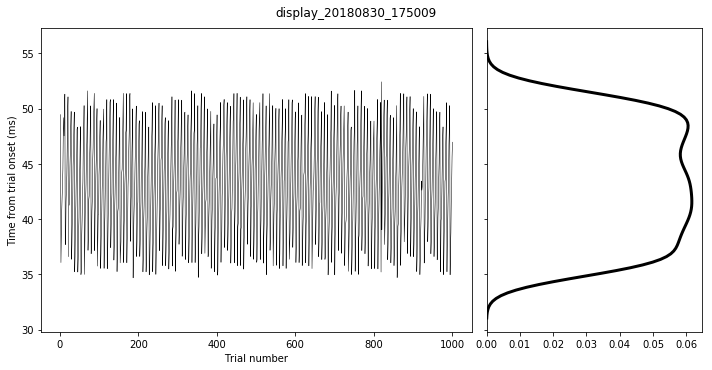

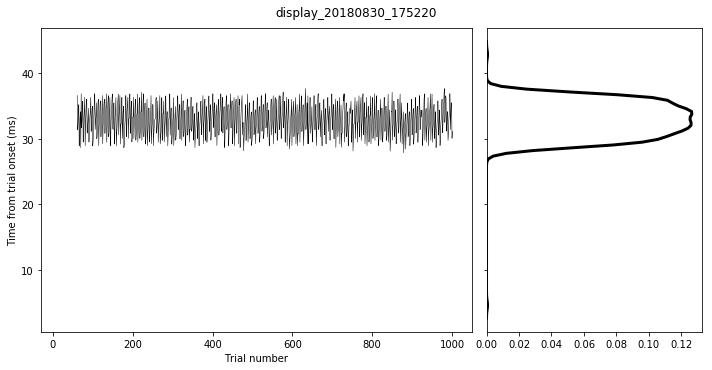

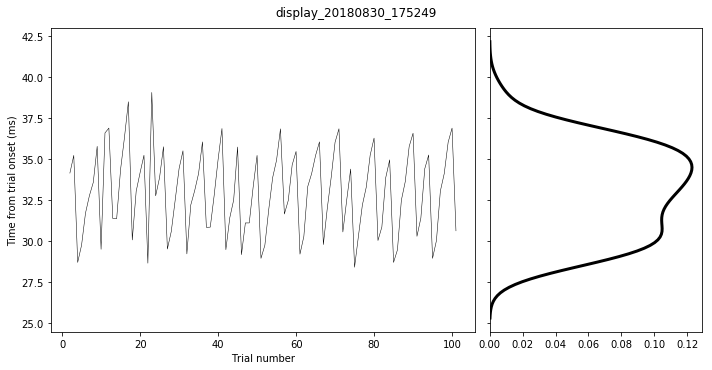

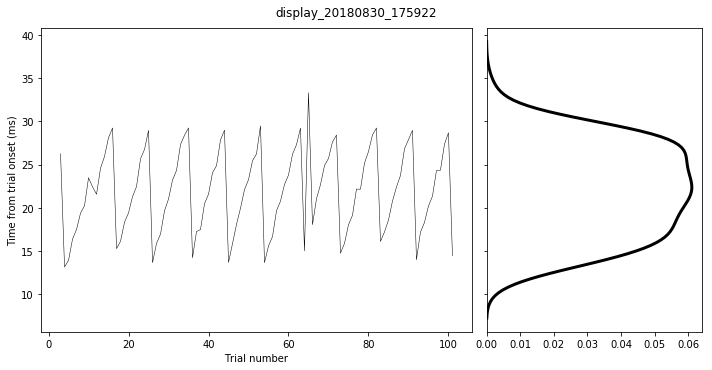

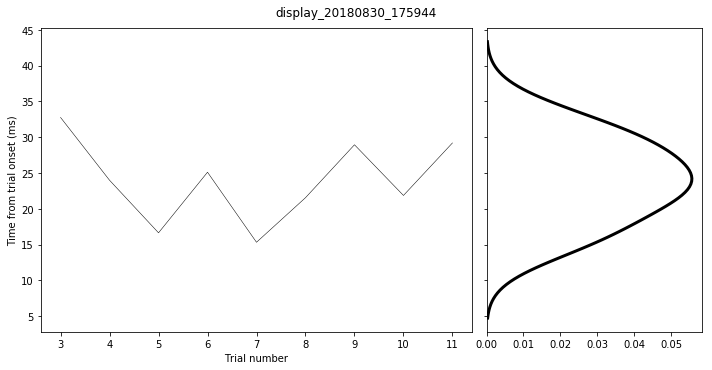

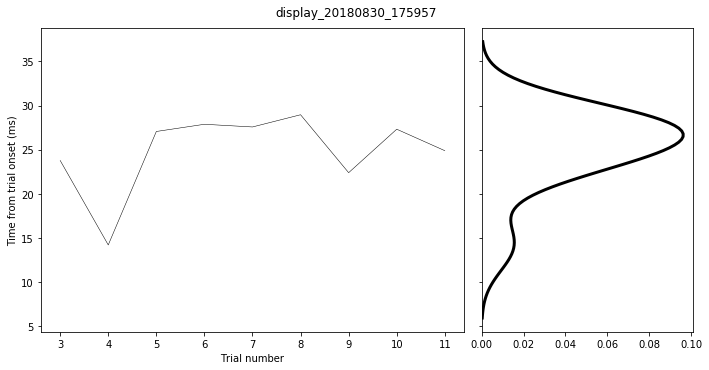

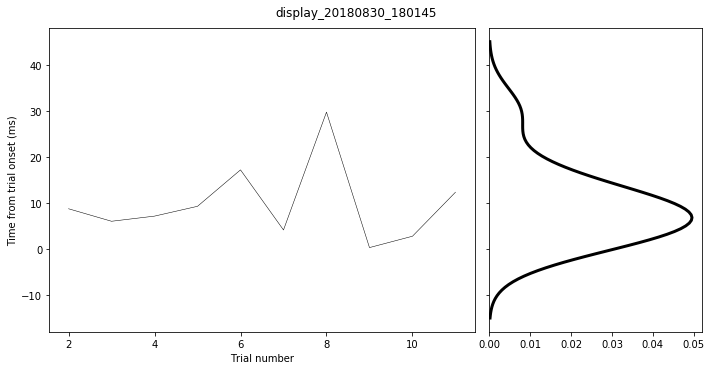

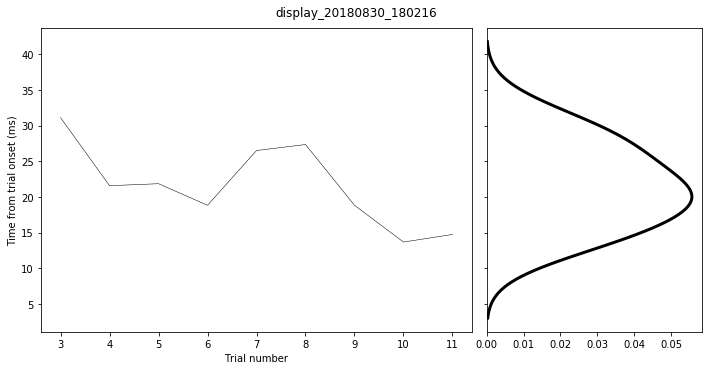

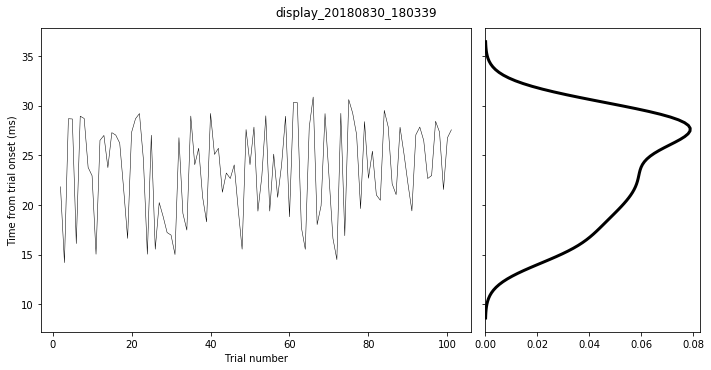

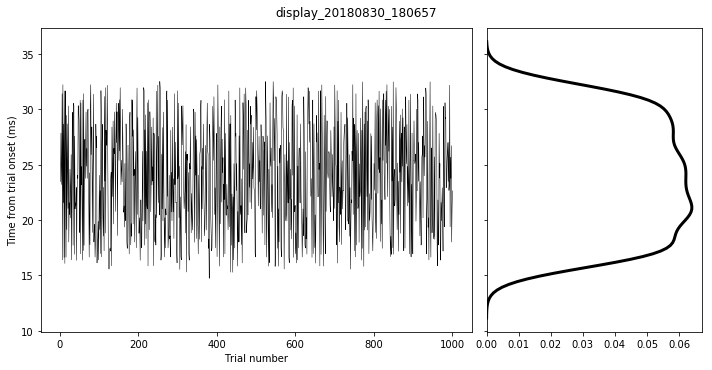

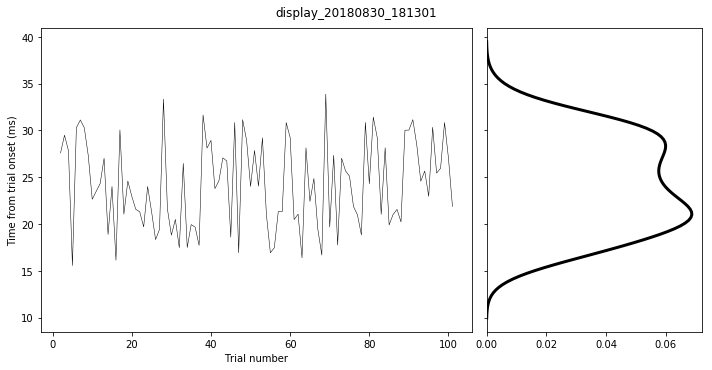

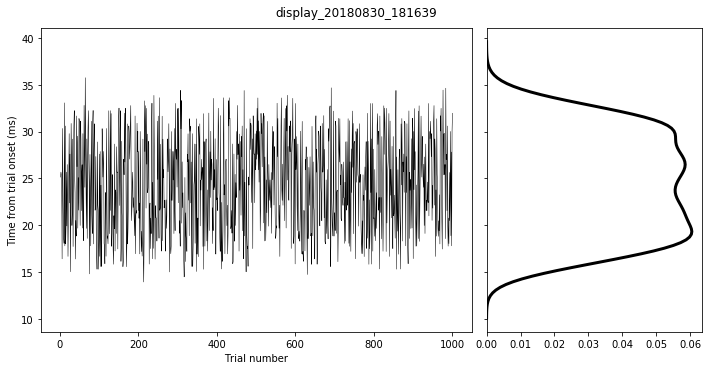

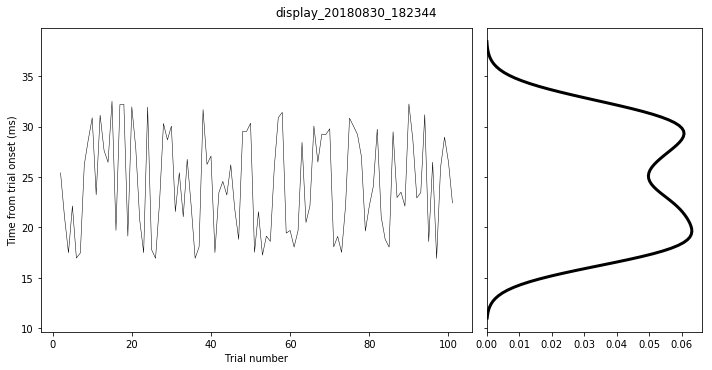

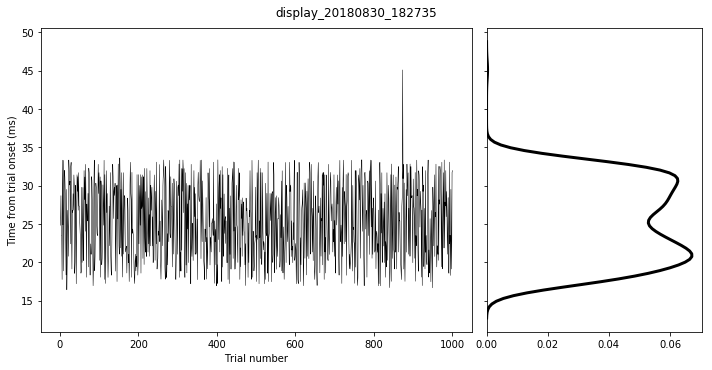

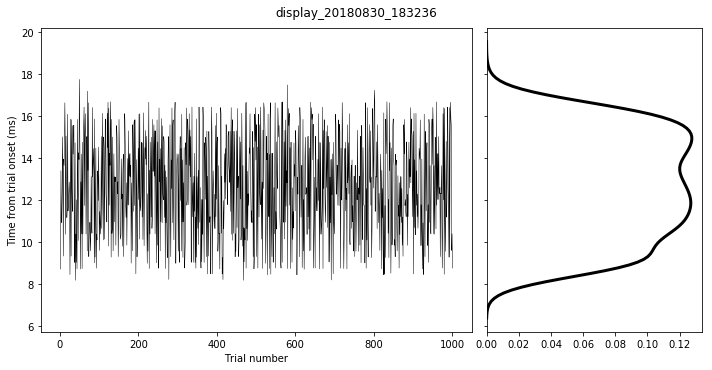

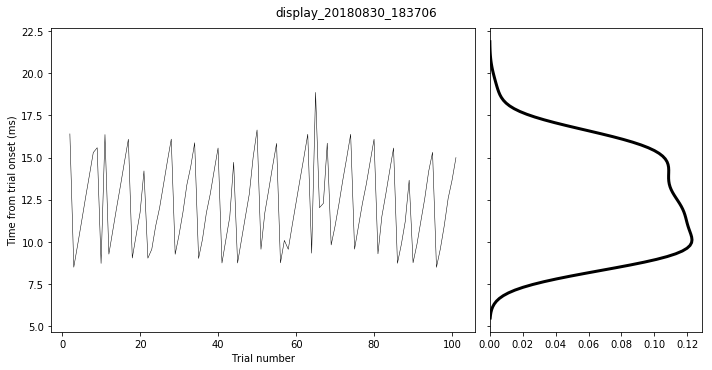

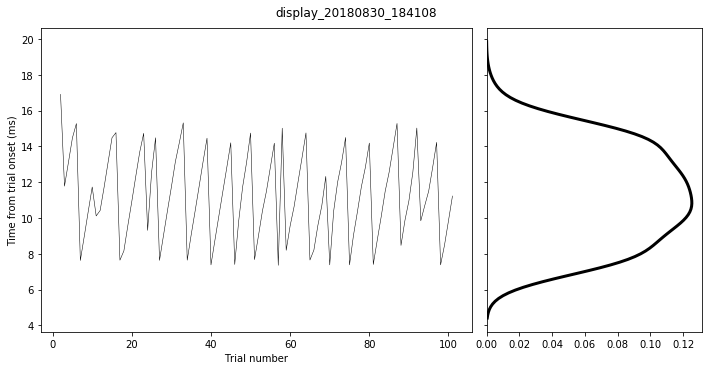

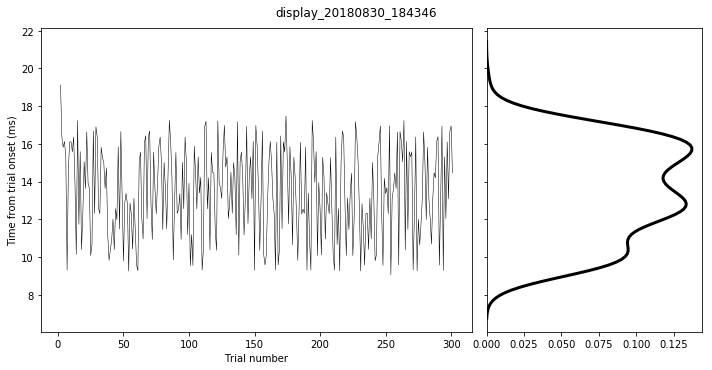

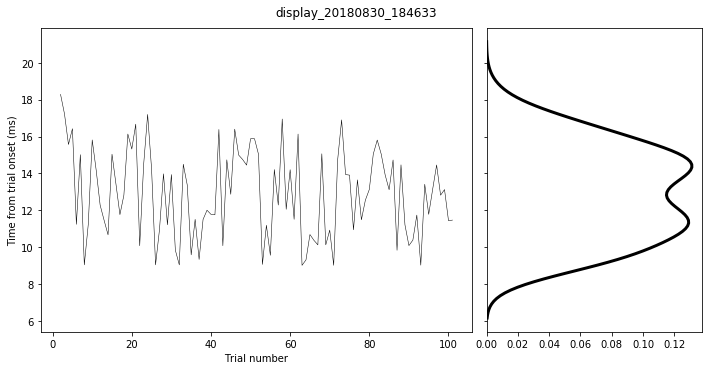

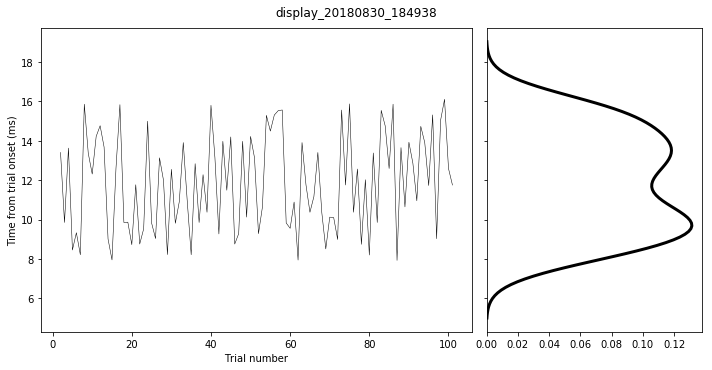

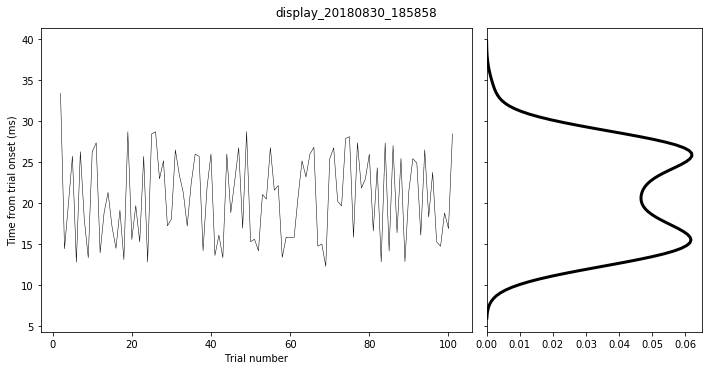

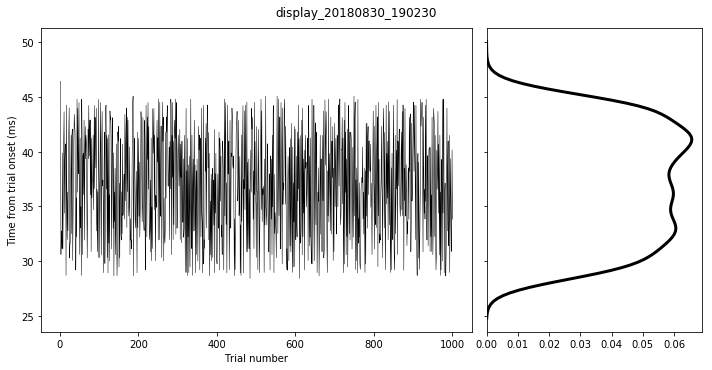

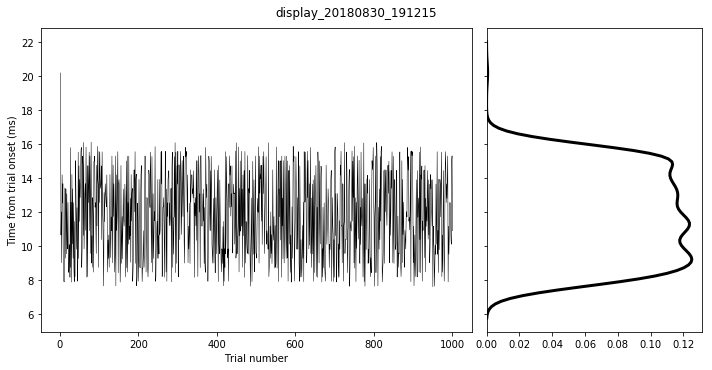

In [17]:
for sess_id in range(0, 28):
    session = dfp.iloc[sess_id].name
    dl = latencies[latencies['Session'] == session]

    fig, axes= plt.subplots(1, 2, figsize=(10, 5), gridspec_kw = {'width_ratios': [2, 1]}, sharey=True)
    (ax1, ax2) = axes

    ax1.plot(dl['Trial'], dl['DisplayLatency'], c='k', linewidth=.5);
    sns.distplot(dl['DisplayLatency'].dropna().values, hist=False, color="k", kde_kws={"linewidth": 3, "alpha": 1}, 
                 ax=axes[1], vertical=True);
    ax1.set(ylabel='Time from trial onset (ms)')
    ax1.set_xlabel('Trial number')

    fig.tight_layout(w_pad=0)
    fig.suptitle(session, y=1.02)
    fig;
    plt.savefig(path_fig + session + '_' + str(sess_id) + '_latencies.png')

---

## Aggregation analysis

In [76]:
df_data = df_data_all.copy()
df_params = df_params_all.copy()

Merge the df_data_all with df_latency

In [82]:
df_data_latency = pd.merge(df_data_all, df_latency, on=['Session', 'Trial'])
df_data_latency.tail()

Trial 
 Time 
 SensorBrightness 
 Session 
 Latency 
 
 
 
 
 2547995 
 1001 
 143434284 
 604 
 27 
 10912.0 
 
 
 2547996 
 1001 
 143434556 
 606 
 27 
 10912.0 
 
 
 2547997 
 1001 
 143434828 
 604 
 27 
 10912.0 
 
 
 2547998 
 1001 
 143435100 
 604 
 27 
 10912.0 
 
 
 2547999 
 1001 
 143435372 
 606 
 27 
 10912.0

Merge the df_params_all with df_latency

In [86]:
df_params_latency = pd.merge(df_latency, df_params, on='Session')
df_params_latency.head()

Session 
 Trial 
 Latency 
 Experiment 
 Date 
 Time 
 Width 
 Height 
 Depth 
 Rate 
 Monitors 
 Trials 
 Filename 
 
 
 
 
 0 
 0 
 2 
 38488.0 
 DisplayExperiment 
 30.08.2018 
 11:51:10 
 1920 
 1080 
 32 
 60 
 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009 
 1000 
 display_20180830_115317 
 
 
 1 
 0 
 3 
 29504.0 
 DisplayExperiment 
 30.08.2018 
 11:51:10 
 1920 
 1080 
 32 
 60 
 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009 
 1000 
 display_20180830_115317 
 
 
 2 
 0 
 4 
 28664.0 
 DisplayExperiment 
 30.08.2018 
 11:51:10 
 1920 
 1080 
 32 
 60 
 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009 
 1000 
 display_20180830_115317 
 
 
 3 
 0 
 5 
 19376.0 
 DisplayExperiment 
 30.08.2018 
 11:51:10 
 1920 
 1080 
 32 
 60 
 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009 
 1000 
 display_20180830_115317 
 
 
 4 
 0 
 6 
 34672.0 
 DisplayExperiment 
 30.08.2018 
 11:51:10 
 1920 
 1080 
 32 
 60 
 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009 
 1000 
 display_20180830_115317

Merge the df_data_latency with the df_params_all

In [83]:
df = pd.merge(df_data_latency, df_params, on='Session')
df = df.rename(columns={'Time_x': 'Time', 'Time_y': 'Exp_Time'})
df.head()

Trial 
 Time 
 SensorBrightness 
 Session 
 Latency 
 Experiment 
 Date 
 Exp_Time 
 Width 
 Height 
 Depth 
 Rate 
 Monitors 
 Trials 
 Filename 
 
 
 
 
 0 
 2 
 813068 
 0 
 0 
 38488.0 
 DisplayExperiment 
 30.08.2018 
 11:51:10 
 1920 
 1080 
 32 
 60 
 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009 
 1000 
 display_20180830_115317 
 
 
 1 
 2 
 813340 
 0 
 0 
 38488.0 
 DisplayExperiment 
 30.08.2018 
 11:51:10 
 1920 
 1080 
 32 
 60 
 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009 
 1000 
 display_20180830_115317 
 
 
 2 
 2 
 813612 
 0 
 0 
 38488.0 
 DisplayExperiment 
 30.08.2018 
 11:51:10 
 1920 
 1080 
 32 
 60 
 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009 
 1000 
 display_20180830_115317 
 
 
 3 
 2 
 813884 
 0 
 0 
 38488.0 
 DisplayExperiment 
 30.08.2018 
 11:51:10 
 1920 
 1080 
 32 
 60 
 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009 
 1000 
 display_20180830_115317 
 
 
 4 
 2 
 814156 
 0 
 0 
 38488.0 
 DisplayExperiment 
 30.08.2018 
 11:51:10 
 1920 
 1080 
 32 
 60 
 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009 
 1000 
 display_20180830_115317

---

Now we have different dataframes available, we can chose one and perform out analysis on it

In [116]:
df = df_params_latency.copy()

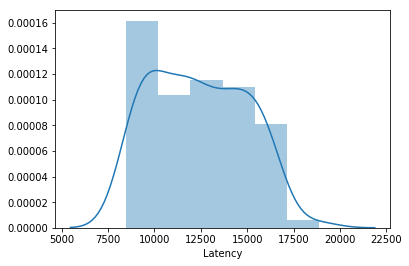

In [96]:
grp = df.groupby('Session')
dff = grp.get_group(20)
sns.distplot(dff.Latency)

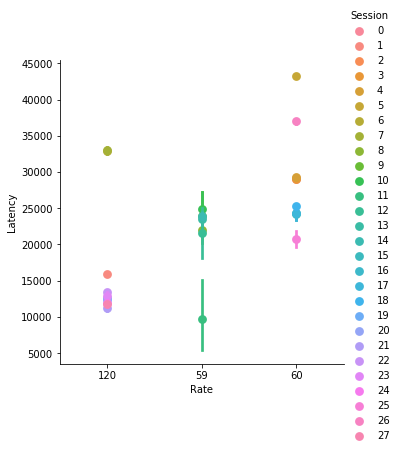

In [99]:
sns.catplot(x='Rate', y='Latency', hue='Session', kind="point", data=df)

## Same monitor, different parameters

In [176]:
df = df_params_latency.copy()

In [177]:
for ind, (name, dff) in enumerate(df.groupby('Monitors')):
    print(ind, name)

0 BNQ_BQ XL411_H6E00549SL0
1 SAM_SycMastr_H9XQB10798
2 SAM_SycMastr_H9XS904970
3 SAM_SycMastr_H9XS904970 | OTM_Optoa WXGA_Q8TV3170464
4 SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009


In [195]:
grp = df.groupby('Monitors')
name = list(grp)[0][0]
df_mon = grp.get_group(name)
df_mon.head()

Session 
 Trial 
 Latency 
 Experiment 
 Date 
 Time 
 Width 
 Height 
 Depth 
 Rate 
 Monitors 
 Trials 
 Filename 
 
 
 
 
 9440 
 17 
 2 
 25416.0 
 DisplayExperiment 
 30.08.2018 
 18:23:28 
 1920 
 1080 
 32 
 60 
 BNQ_BQ XL411_H6E00549SL0 
 100 
 display_20180830_182344 
 
 
 9441 
 17 
 3 
 21040.0 
 DisplayExperiment 
 30.08.2018 
 18:23:28 
 1920 
 1080 
 32 
 60 
 BNQ_BQ XL411_H6E00549SL0 
 100 
 display_20180830_182344 
 
 
 9442 
 17 
 4 
 17472.0 
 DisplayExperiment 
 30.08.2018 
 18:23:28 
 1920 
 1080 
 32 
 60 
 BNQ_BQ XL411_H6E00549SL0 
 100 
 display_20180830_182344 
 
 
 9443 
 17 
 5 
 22120.0 
 DisplayExperiment 
 30.08.2018 
 18:23:28 
 1920 
 1080 
 32 
 60 
 BNQ_BQ XL411_H6E00549SL0 
 100 
 display_20180830_182344 
 
 
 9444 
 17 
 6 
 16952.0 
 DisplayExperiment 
 30.08.2018 
 18:23:28 
 1920 
 1080 
 32 
 60 
 BNQ_BQ XL411_H6E00549SL0 
 100 
 display_20180830_182344

Monitor: BNQ_BQ XL411_H6E00549SL0


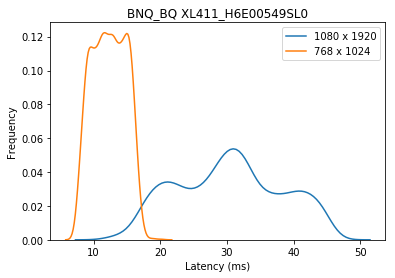

Monitor: SAM_SycMastr_H9XQB10798


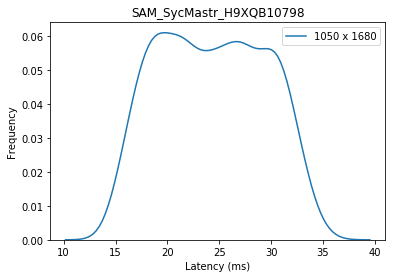

Monitor: SAM_SycMastr_H9XS904970
Monitor: SAM_SycMastr_H9XS904970 | OTM_Optoa WXGA_Q8TV3170464
Monitor: SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009


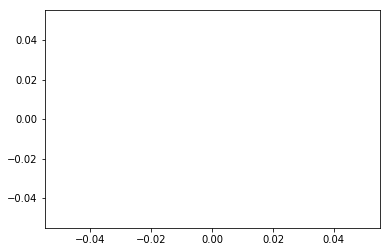

In [204]:
for name, df_mon in df.groupby('Monitors'):
    print('Monitor:', name)
    try:
        for (h, w), df_res in df_mon.groupby(['Height','Width']):
            sns.distplot(df_res.Latency / 1000, hist=False, label=h + ' x ' + w)
        
        plt.title(name)
        plt.xlabel('Latency (ms)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig('C:/Users/Mohammad Bashiri/Desktop/single-mon' + name + '.png')
        plt.show()
    except ValueError:
        pass

Monitor: BNQ_BQ XL411_H6E00549SL0


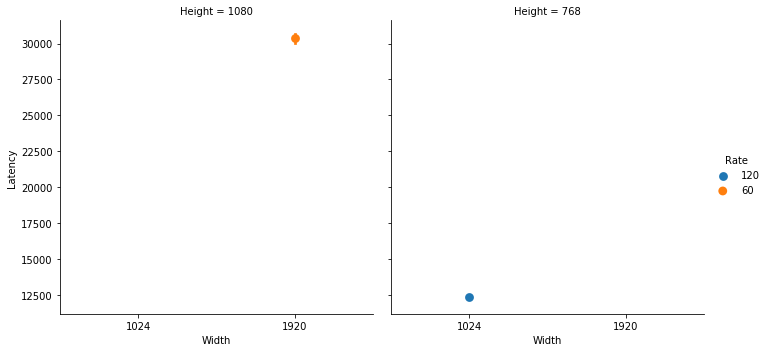

Monitor: SAM_SycMastr_H9XQB10798


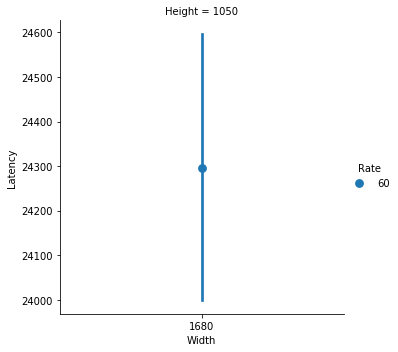

Monitor: SAM_SycMastr_H9XS904970


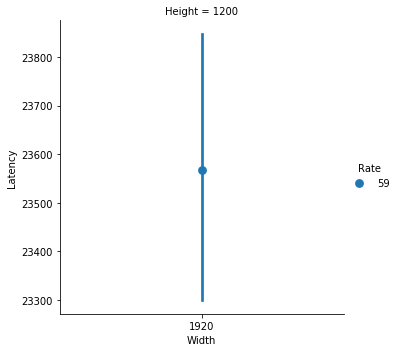

Monitor: SAM_SycMastr_H9XS904970 | OTM_Optoa WXGA_Q8TV3170464


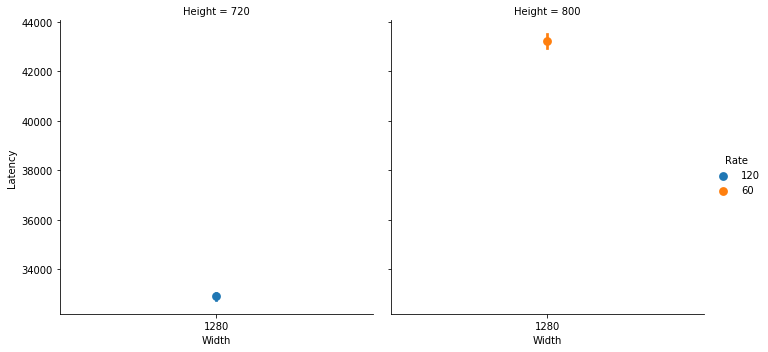

Monitor: SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009


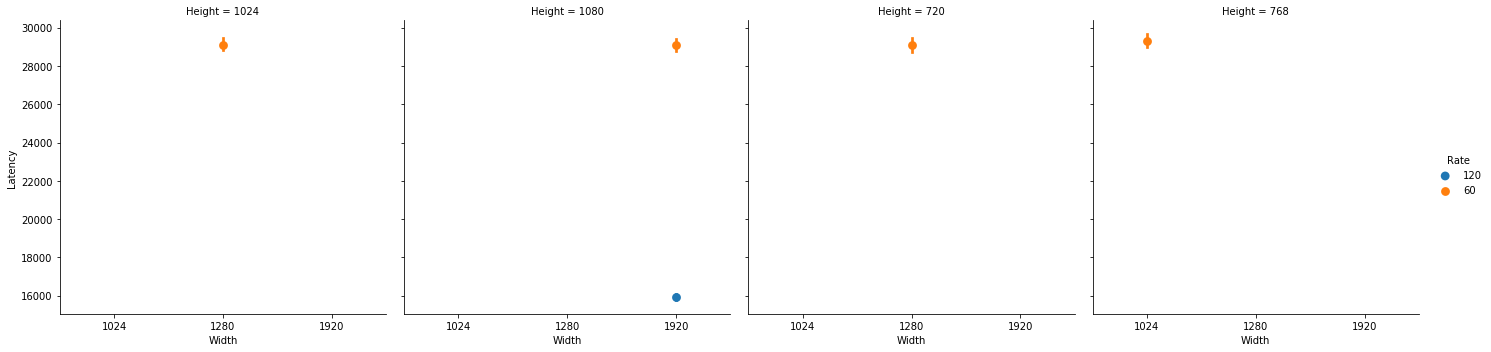

In [208]:
for name, df_mon in df.groupby('Monitors'):
    print('Monitor:', name)
    try:
        sns.catplot(x='Width', y='Latency', hue='Rate', col='Height', kind="point", data=df_mon)
        
#         plt.title(name)
#         plt.legend()
#         plt.savefig('C:/Users/Mohammad Bashiri/Desktop/single-mon' + name + '.png')
        plt.show()
    except ValueError:
        pass

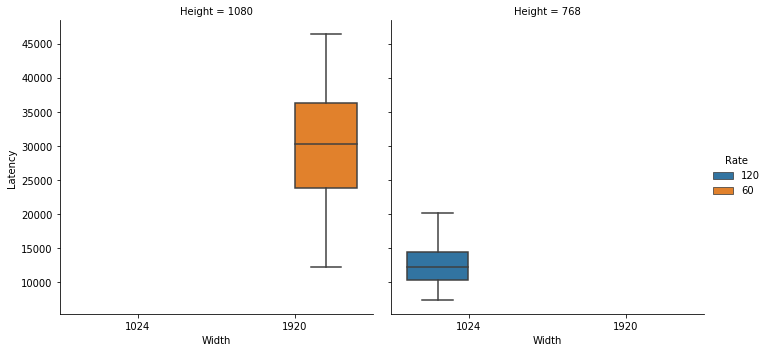

In [196]:
sns.catplot(x='Width', y='Latency', hue='Rate', col='Height', kind="box", data=df_mon)

## Same paramet different monitor

In [172]:
df = df_params_latency.copy()

In [173]:
grp = df.groupby(['Height', 'Width'])

('1024', '1280') ['SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009']
('1050', '1680') ['SAM_SycMastr_H9XQB10798']
('1080', '1920') ['SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009' 'BNQ_BQ XL411_H6E00549SL0']
('1200', '1920') ['SAM_SycMastr_H9XS904970']
('720', '1280') ['SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009'
 'SAM_SycMastr_H9XS904970 | OTM_Optoa WXGA_Q8TV3170464']
('768', '1024') ['SAM_SycMastr_H9XS904970 | VX_ROCtr_16843009' 'BNQ_BQ XL411_H6E00549SL0']
('800', '1280') ['SAM_SycMastr_H9XS904970 | OTM_Optoa WXGA_Q8TV3170464']


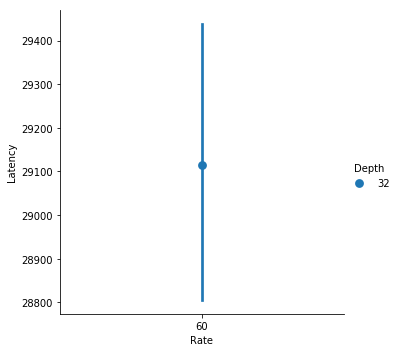

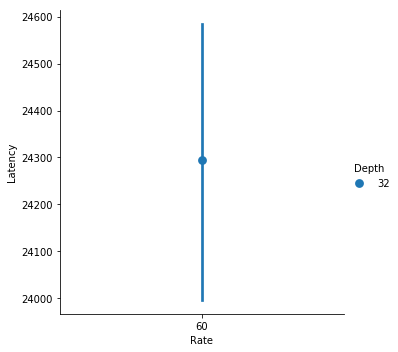

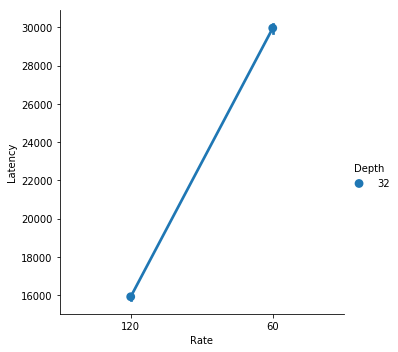

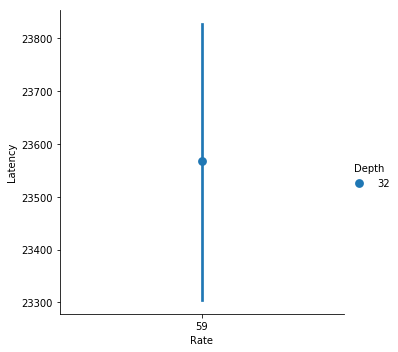

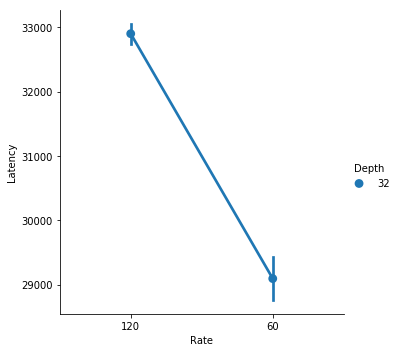

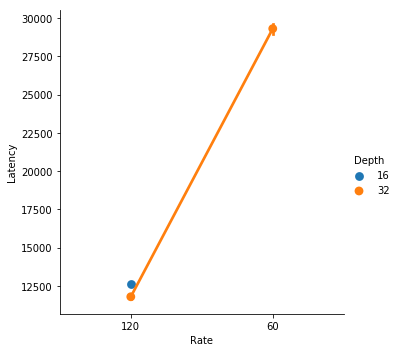

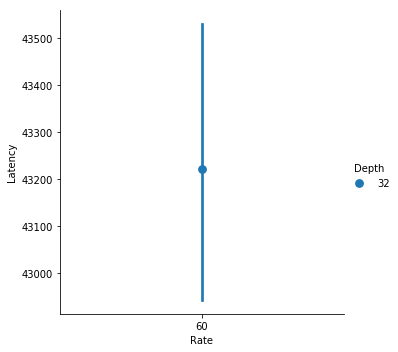

In [175]:
for name, dff in grp:
    print(name, dff.Monitors.unique())
    sns.catplot(x='Rate', y='Latency', hue='Depth', kind='point', data=dff)